## Custom Model Training for Emotion, Age, and Gender Classification

The purpose of this notebook is to perform custom training of three binary classification models using TensorFlow and Keras.

* **Emotion model**: This model is used to classify between happy vs sad. It is trained on a subset of the FER-2013 dataset, using only the happy and sad classes. It uses a custom CNN model with greyscale 48x48 images. It is designed to be compact for later deployment for mobile/web environments.
* **Age model:** This model is designed for binary classification between adults and elderly. It is trained on the UTKFace dataset. It uses a MobileNetV2-based binary classifier on resized 224×224 RGB images.
* **Gender model**: This model is designed for binary classification between male and female. It is trained on the UTKFace dataset, using using MobileNetV2 in the same way as the age model.
* The trained models will be saved as .h5 files, and will be converted to TF.js or TFLite in the next phase.


**1. Setting up the environment**

In [ ]:
!pip install \
  numpy==1.25.2 \
  tensorflow==2.15.0 \
  keras==2.15.0 \
  protobuf==4.25.3 \
  wrapt==1.14.1 \
  ml-dtypes==0.2.0 \
  tensorflow-estimator==2.15.0 \
  tensorboard==2.15.1 \
  --no-deps --force-reinstall

In [35]:
import numpy as np
import tensorflow as tf
import keras

print("✅ NumPy:", np.__version__)
print("✅ TensorFlow:", tf.__version__)
print("✅ Keras:", keras.__version__)

✅ NumPy: 1.25.2
✅ TensorFlow: 2.15.0
✅ Keras: 2.15.0


In [36]:
import os
import cv2
import numpy as np
import pandas as pd
from IPython.display import display
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K

In [ ]:
import kagglehub

# Download latest version FER-2013
path = kagglehub.dataset_download("msambare/fer2013")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/fer2013


In [ ]:
!ls /kaggle/input/fer2013/


test  train


In [ ]:
# Download latest version UTKFace
path = kagglehub.dataset_download("jangedoo/utkface-new")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/utkface-new


In [38]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [37]:
# Define paths
DRIVE_PATH = "/content/drive/MyDrive/Edge_AI_Project"
MODEL_PATH = os.path.join(DRIVE_PATH, "models/saved_models")
LOG_PATH = os.path.join(DRIVE_PATH, "models/logs")
os.makedirs(MODEL_PATH, exist_ok=True)
os.makedirs(LOG_PATH, exist_ok=True)
utkface_dir = "/kaggle/input/utkface-new/UTKFace"
emotion_train_dir = "/kaggle/input/fer2013/train"
emotion_test_dir = "/kaggle/input/fer2013/test"

**2. Training the models**

The training function has been designed to find a balance between accuracy and avoiding RAM usage crashes.
We will use a low batch size of 8. The models are trained using 10 epochs. This increases training time, but does increase accuray with minimal impact on RAM usage.
The trained models for age, gender and emotion will be saved with performance metrics logged.
After training each model, the session will be cleared before the next model is trained.

In [39]:
# Load UTKFace subset
def load_utkface_subset(data_dir, task='age', max_samples=2000):
    data = []
    count = 0
    for file in os.listdir(data_dir):
        if file.endswith('.jpg'):
            parts = file.split('_')
            if len(parts) < 2: continue
            age = int(parts[0])
            gender = int(parts[1])
            img = cv2.imread(os.path.join(data_dir, file))
            if img is None: continue
            img = cv2.resize(img, (224, 224))
            label = 0 if (task == 'age' and age < 50) else 1 if task == 'age' else gender
            data.append((img, label))
            count += 1
            if count >= max_samples: break
    X, y = zip(*data)
    return np.array(X).astype('float32') / 255.0, np.array(y)

def prepare_data(X, y):
    return train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

def build_mobilenet_classifier():
    base = MobileNetV2(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
    x = GlobalAveragePooling2D()(base.output)
    x = Dense(1, activation='sigmoid')(x)
    return Model(inputs=base.input, outputs=x)

In [40]:
# Setting up the training and logging function
def train_and_log(model, X_train, y_train, X_val, y_val, name, epochs=10):
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    if y_train is None and y_val is None:
        # If using generators
        history = model.fit(
            X_train,
            validation_data=X_val,
            epochs=epochs,
            batch_size=8
        )
    else:
        # If using arrays (age/gender)
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=8
        )

    model.save(os.path.join(MODEL_PATH, f"{name}.h5"))
    print(f"✅ Saved {name}.h5")

    hist_df = pd.DataFrame(history.history)
    hist_df.index.name = 'epoch'
    hist_df.to_csv(os.path.join(LOG_PATH, f"{name}_log.csv"))
    print(f"✅ Saved {name}_log.csv")

    K.clear_session()
    return history



**3. Training the Emotion model**

The emotion model is designed for binary classification between happy and sad. The original FER2013 dataset contains data for 7 emotions, but we will use only the "happy" and "sad" subfolders to train the model.

In [ ]:
# Build emotion model
def build_emotion_model():
    inputs = Input(shape=(48, 48, 1))
    x = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    return tf.keras.Model(inputs, x)

In [ ]:
import os
import shutil

# Source paths
source_train = "/kaggle/input/fer2013/train"
source_test = "/kaggle/input/fer2013/test"

# Target paths
target_train = "/content/emotion_binary/train"
target_test = "/content/emotion_binary/test"

# Emotion folders to keep
target_classes = ['happy', 'sad']

for cls in target_classes:
    os.makedirs(os.path.join(target_train, cls), exist_ok=True)
    os.makedirs(os.path.join(target_test, cls), exist_ok=True)

    # Copy training images
    src_cls_train = os.path.join(source_train, cls)
    tgt_cls_train = os.path.join(target_train, cls)
    for fname in os.listdir(src_cls_train):
        shutil.copy(os.path.join(src_cls_train, fname), os.path.join(tgt_cls_train, fname))

    # Copy test images
    src_cls_test = os.path.join(source_test, cls)
    tgt_cls_test = os.path.join(target_test, cls)
    for fname in os.listdir(src_cls_test):
        shutil.copy(os.path.join(src_cls_test, fname), os.path.join(tgt_cls_test, fname))

print("✅ Filtered dataset created at /content/emotion_binary")

✅ Filtered dataset created at /content/emotion_binary


In [ ]:
emotion_train_dir = "/content/emotion_binary/train"
emotion_test_dir = "/content/emotion_binary/test"

In [ ]:
# Train Emotion Model
datagen = ImageDataGenerator(rescale=1./255)
train_generator = datagen.flow_from_directory(emotion_train_dir, target_size=(48, 48),
    color_mode='grayscale', class_mode='binary', batch_size=8, shuffle=True)
test_generator = datagen.flow_from_directory(emotion_test_dir, target_size=(48, 48),
    color_mode='grayscale', class_mode='binary', batch_size=8, shuffle=False)

emotion_model = build_emotion_model()
emotion_history = train_and_log(
    emotion_model,
    train_generator,
    None,  # y_train not needed for generators
    test_generator,
    None,  # y_val not needed for generators
    name='emotion_model'
)

Found 12045 images belonging to 2 classes.
Found 3021 images belonging to 2 classes.
Epoch 1/10
1506/1506 [==============================] - 179s 117ms/step - loss: 0.5767 - accuracy: 0.7232 - val_loss: 1.7637 - val_accuracy: 0.5276
Epoch 2/10
1506/1506 [==============================] - 179s 119ms/step - loss: 0.4581 - accuracy: 0.7739 - val_loss: 0.5779 - val_accuracy: 0.6991
Epoch 3/10
1506/1506 [==============================] - 176s 117ms/step - loss: 0.3782 - accuracy: 0.8193 - val_loss: 0.4272 - val_accuracy: 0.7905
Epoch 4/10
1506/1506 [==============================] - 179s 119ms/step - loss: 0.3630 - accuracy: 0.8356 - val_loss: 1105.9163 - val_accuracy: 0.5879
Epoch 5/10
1506/1506 [==============================] - 189s 125ms/step - loss: 0.3120 - accuracy: 0.8486 - val_loss: 0.4189 - val_accuracy: 0.8136
Epoch 6/10
1506/1506 [==============================] - 180s 119ms/step - loss: 0.2709 - accuracy: 0.8749 - val_loss: 0.5131 - val_accuracy: 0.7829
Epoch 7/10
1506/1506 [==

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import os

emotion_model_path = os.path.join(MODEL_PATH, "emotion_model.h5")
emotion_log_path = os.path.join(LOG_PATH, "emotion_model_log.csv")

# Check existence
model_exists = os.path.exists(emotion_model_path)
log_exists = os.path.exists(emotion_log_path)

print("✅ Emotion model file saved:" if model_exists else "❌ Emotion model file NOT found")
print("✅ Emotion log file saved:" if log_exists else "❌ Emotion log file NOT found")

# Optionally show last row of log
if log_exists:
    import pandas as pd
    df = pd.read_csv(emotion_log_path)
    print("\n🔍 Final Epoch Results:")
    display(df.tail(1))


✅ Emotion model file saved:
✅ Emotion log file saved:

🔍 Final Epoch Results:


,epoch,loss,accuracy,val_loss,val_accuracy
9,9,0.157471,0.927771,0.547754,0.798411


**4. Training the age and gender models**

In [41]:
# Train Age Model
age_model = build_mobilenet_classifier()
age_history = train_and_log(age_model, X_train, y_train, X_val, y_val, name='age_model')

# Train Gender Model
gender_model = build_mobilenet_classifier()
gender_history = train_and_log(gender_model, X_train, y_train, X_val, y_val, name='gender_model')


Epoch 1/10
200/200 [==============================] - 314s 1s/step - loss: 0.5301 - accuracy: 0.7481 - val_loss: 4.2809 - val_accuracy: 0.4925
Epoch 2/10
200/200 [==============================] - 287s 1s/step - loss: 0.4243 - accuracy: 0.8081 - val_loss: 3.0574 - val_accuracy: 0.4900
Epoch 3/10
200/200 [==============================] - 292s 1s/step - loss: 0.3689 - accuracy: 0.8431 - val_loss: 1.7834 - val_accuracy: 0.5150
Epoch 4/10
200/200 [==============================] - 297s 1s/step - loss: 0.2907 - accuracy: 0.8844 - val_loss: 0.6400 - val_accuracy: 0.7225
Epoch 5/10
200/200 [==============================] - 294s 1s/step - loss: 0.2440 - accuracy: 0.9000 - val_loss: 2.3716 - val_accuracy: 0.5150
Epoch 6/10
200/200 [==============================] - 301s 2s/step - loss: 0.2044 - accuracy: 0.9169 - val_loss: 0.6337 - val_accuracy: 0.8225
Epoch 7/10
200/200 [==============================] - 293s 1s/step - loss: 0.2097 - accuracy: 0.9300 - val_loss: 0.8154 - val_accuracy: 0.7550

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


✅ Saved age_model.h5
✅ Saved age_model_log.csv
Epoch 1/10
200/200 [==============================] - 321s 1s/step - loss: 0.5716 - accuracy: 0.7362 - val_loss: 1.5533 - val_accuracy: 0.5125
Epoch 2/10
200/200 [==============================] - 282s 1s/step - loss: 0.4262 - accuracy: 0.8025 - val_loss: 1.2851 - val_accuracy: 0.5425
Epoch 3/10
200/200 [==============================] - 290s 1s/step - loss: 0.3144 - accuracy: 0.8687 - val_loss: 0.8987 - val_accuracy: 0.6600
Epoch 4/10
200/200 [==============================] - 289s 1s/step - loss: 0.2805 - accuracy: 0.8831 - val_loss: 0.6934 - val_accuracy: 0.7600
Epoch 5/10
200/200 [==============================] - 281s 1s/step - loss: 0.2250 - accuracy: 0.9106 - val_loss: 2.4475 - val_accuracy: 0.5825
Epoch 6/10
200/200 [==============================] - 288s 1s/step - loss: 0.2158 - accuracy: 0.9119 - val_loss: 1.6292 - val_accuracy: 0.6025
Epoch 7/10
200/200 [==============================] - 291s 1s/step - loss: 0.1714 - accuracy: 0

**5. Performance metrics**

In [42]:
# Print final performance summary table
summary = []

for name in ["age_model", "gender_model", "emotion_model"]:
    log_path = os.path.join(LOG_PATH, f"{name}_log.csv")
    if os.path.exists(log_path):
        df = pd.read_csv(log_path)
        final_row = df.iloc[-1]
        summary.append({
            "Model": name.replace("_model", "").capitalize(),
            "Val Accuracy": round(final_row['val_accuracy'], 4),
            "Val Loss": round(final_row['val_loss'], 4)
        })

summary_df = pd.DataFrame(summary)
display(summary_df)

,Model,Val Accuracy,Val Loss
0,Age,0.6875,1.3954
1,Gender,0.6300,1.5487
2,Emotion,0.7984,0.5478


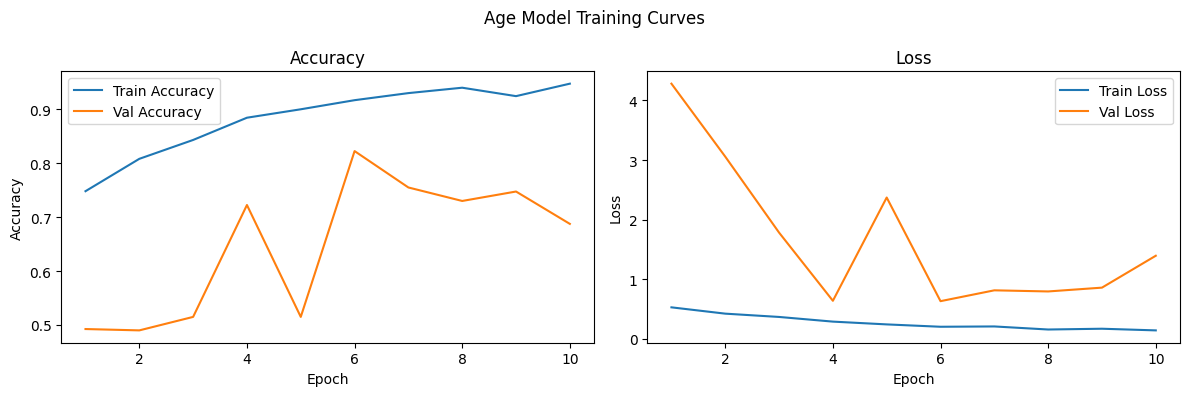

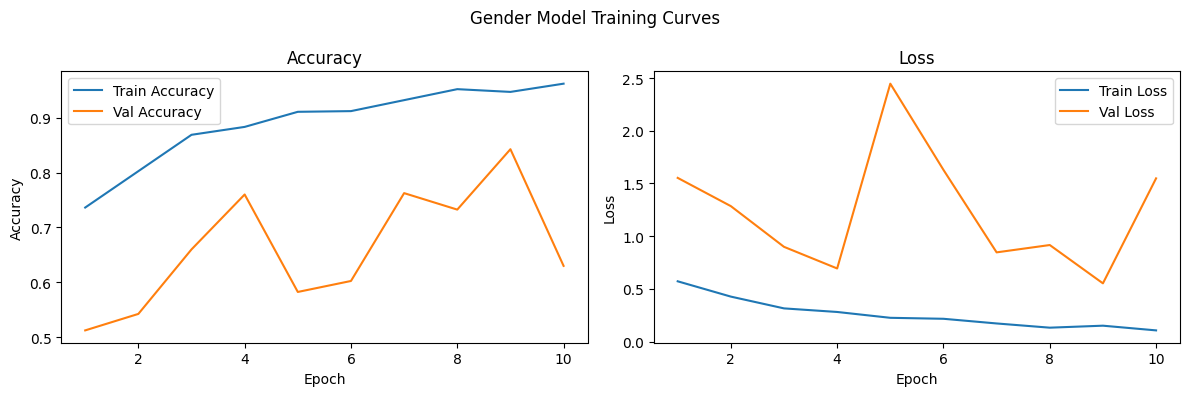

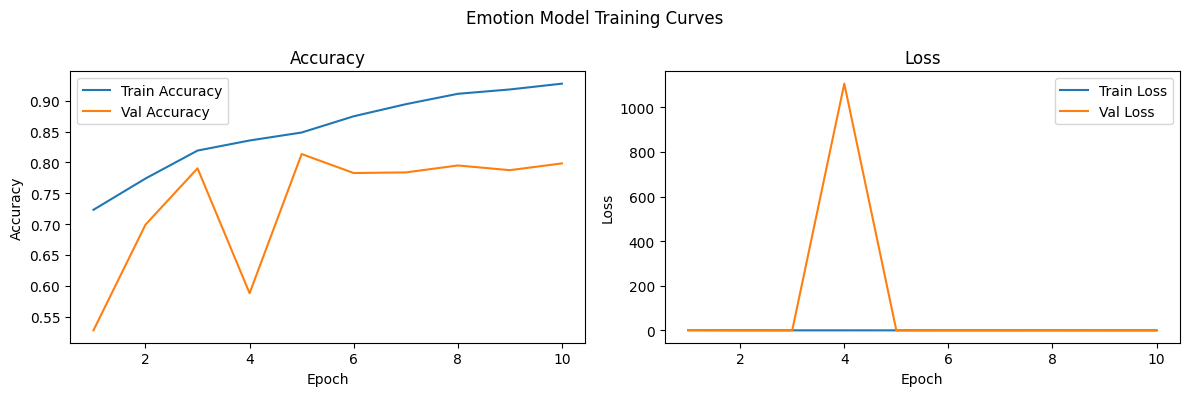

In [43]:
# Plot training and validation curves
import matplotlib.pyplot as plt

def plot_history(log_path, title):
    if not os.path.exists(log_path):
        print(f"❌ Log not found for {title}")
        return
    df = pd.read_csv(log_path)
    epochs = df.index + 1

    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(f'{title} Model Training Curves')

    ax[0].plot(epochs, df['accuracy'], label='Train Accuracy')
    ax[0].plot(epochs, df['val_accuracy'], label='Val Accuracy')
    ax[0].set_title('Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend()

    ax[1].plot(epochs, df['loss'], label='Train Loss')
    ax[1].plot(epochs, df['val_loss'], label='Val Loss')
    ax[1].set_title('Loss')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    ax[1].legend()

    plt.tight_layout()
    plt.show()

# Plot for each model
for name in ["age_model", "gender_model", "emotion_model"]:
    plot_history(os.path.join(LOG_PATH, f"{name}_log.csv"), name.replace("_model", "").capitalize())
